BUSINESS UNDERSTANDING

Introduction

Introduction
Savor Space is a growing tourism and travel agency offering a wide range of services; from booking accommodations to providing tour guides and creating personalized travel experiences. Our mission is to ensure that tourists have an enriching and seamless journey hence fully enjoying their destination.

We believe that traveling is about more than just sightseeing,it's also about savoring local cuisines that suit individual tastes. Whether a tourist is looking for traditional dishes, vegan options, or a fine dining experience, finding their preferred restaurant guarantees a satisfying experience. To enhance this specific aspect of their journey, Savor Space is developing a restaurant recommendation system designed to help tourists discover dining spots that align with their preferences,ensuring a memorable and enjoyable culinary experience.

Business Problem

Its not easy for a majority of tourists to find restaurants that align with their tastes, especially when visiting unfamiliar locations. Lack of personalized recommendations means that they may rely on random reviews, which do not always reflect their preferences or specific dining needs. The lack of tailored suggestions can negatively impact a tourist's overall experience. The problem Savor Space seeks to solve is how to provide accurate and personalized restaurant recommendations based on individual preferences, allowing tourists to easily find eateries they will enjoy.

Stakeholders

Savor Space Management: An interest in offering personalized and innovative services to boost customer satisfaction and retention thus positvely impacting their ROI.

Tourists: Seeking personalized restaurant recommendations that match their tastes hence improving their travel experience.

Restaurant Owners: Although they are not directly involved, they may benefit from increased traffic when their restaurant is recommended in alignment with customer preferences.

Objectives


1. To develop a robust restaurant recommendation system- this offers personalized restaurant suggestions based on user preferences, past behaviors, and restaurant reviews.

2. To improve tourist satisfaction- this is done by enabling them discover restaurants that match their individual tastes, enhancing their overall travel experience.

3. To leverage data science techniques-these include: Natural Language Processing (NLP) and recommendation algorithms (content-based and collaborative filtering) to ensure accurate and reliable recommendations.

4. To evaluate and improve the recommendation system- can be achieved by using advanced models and performance metrics like RMSE to optimize the system's accuracy.

Data Understanding

In order to come up with a cutting edge restaurant recommendation system, we opted to get real-time data from Yelp.com. The data was extracted through web scraping and a total of five json datasets were obtained.

Files Obtained:

business.json
checkin.json
review.json
tips.json
user.json


This restaurant recommendation system leverages two primary datasets namely the business.json and the review.json as the had relevant information required to develop the recmmendation system.

1) Business Dataset

This dataset includes essential information about a variety of restaurants. The columns found in this dataset include:

business_id
name
address
city
state
postal_code
latitude
longitude
stars
review_count
is_open
attributes
categories
hours


2) Review Dataset

This dataset provides insights into user preferences and their dining experiences. The columns in this dataset include:

user_id
business_id
stars
date
text
useful
funny
cool

In [148]:
# importing the necesarry libraries

import collections
import folium
import json 
import numpy as np
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import string
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud



In [149]:
# Initialize an empty list to store the data
json_data = []

# Define the number of lines to read (54380)
lines_to_read = 54380

# Open the JSON file and read the specified number of lines
with open(r"C:\Users\nyaki\Downloads\yelp_academic_dataset_business.json", 'r', encoding='utf-8') as file:
    for i, line in enumerate(file):  
        if i >= lines_to_read:       
            break
        # Load each line as a JSON object
        json_object = json.loads(line)
        json_data.append(json_object)

# Convert the json_data list into a pandas DataFrame
business_df = pd.DataFrame(json_data)

# Display the first few rows of the DataFrame
business_df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


In [150]:
import csv
# adjust this value according to your memory constraints
chunk_size = 1000  

with open(r"C:\Users\nyaki\Downloads\yelp_academic_dataset_review.json", 'r') as f:
    with open('yelp_review_sample.csv', 'w', newline='') as csvfile:
        fieldnames = ['review_id', 'user_id', 'business_id', 'stars', 'date', 'text', 'useful', 'funny', 'cool']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        count = 0
        for line in f:
# parse each line as a separate JSON object
            data = json.loads(line)  
            writer.writerow(data)
            count += 1
            if count >= 54380:
                break
 

In [151]:
review_df = pd.read_csv('yelp_review_sample.csv')

# Display the first few rows of the Data
review_df.head()

,review_id,user_id,business_id,stars,date,text,useful,funny,cool
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,2018-07-07 22:09:11,"If you decide to eat here, just be aware it is...",0,0,0
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,2012-01-03 15:28:18,I've taken a lot of spin classes over the year...,1,0,1
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,2014-02-05 20:30:30,Family diner. Had the buffet. Eclectic assortm...,0,0,0
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,2015-01-04 00:01:03,"Wow! Yummy, different, delicious. Our favo...",1,0,1
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,2017-01-14 20:54:15,Cute interior and owner (?) gave us tour of up...,1,0,1


In [152]:
# viewing the datas features
business_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54380 entries, 0 to 54379
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   business_id   54380 non-null  object 
 1   name          54380 non-null  object 
 2   address       54380 non-null  object 
 3   city          54380 non-null  object 
 4   state         54380 non-null  object 
 5   postal_code   54380 non-null  object 
 6   latitude      54380 non-null  float64
 7   longitude     54380 non-null  float64
 8   stars         54380 non-null  float64
 9   review_count  54380 non-null  int64  
 10  is_open       54380 non-null  int64  
 11  attributes    49543 non-null  object 
 12  categories    54342 non-null  object 
 13  hours         45975 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 5.8+ MB


In [153]:

review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54380 entries, 0 to 54379
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   review_id    54380 non-null  object 
 1   user_id      54380 non-null  object 
 2   business_id  54380 non-null  object 
 3   stars        54380 non-null  float64
 4   date         54380 non-null  object 
 5   text         54380 non-null  object 
 6   useful       54380 non-null  int64  
 7   funny        54380 non-null  int64  
 8   cool         54380 non-null  int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 3.7+ MB


In [154]:
# merging the two datasets into one using the business_id primary key

restaurant_df=pd.merge(left=review_df , right=business_df, how='left', on='business_id')

# previewing the new merge dataset
restaurant_df.head()

,review_id,user_id,business_id,stars_x,date,text,useful,funny,cool,name,...,state,postal_code,latitude,longitude,stars_y,review_count,is_open,attributes,categories,hours
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,2018-07-07 22:09:11,"If you decide to eat here, just be aware it is...",0,0,0,Turning Point of North Wales,...,PA,19454,40.210196,-75.223639,3.0,169,1,"{'NoiseLevel': 'u'average'', 'HasTV': 'False',...","Restaurants, Breakfast & Brunch, Food, Juice B...","{'Monday': '7:30-15:0', 'Tuesday': '7:30-15:0'..."
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,2012-01-03 15:28:18,I've taken a lot of spin classes over the year...,1,0,1,Body Cycle Spinning Studio,...,PA,19119,39.952103,-75.172753,5.0,144,0,"{'BusinessAcceptsCreditCards': 'True', 'GoodFo...","Active Life, Cycling Classes, Trainers, Gyms, ...","{'Monday': '6:30-20:30', 'Tuesday': '6:30-20:3..."
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,2014-02-05 20:30:30,Family diner. Had the buffet. Eclectic assortm...,0,0,0,Kettle Restaurant,...,AZ,85713,32.207233,-110.980864,3.5,47,1,"{'RestaurantsReservations': 'True', 'BusinessP...","Restaurants, Breakfast & Brunch",None
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,2015-01-04 00:01:03,"Wow! Yummy, different, delicious. Our favo...",1,0,1,Zaika,...,PA,19114,40.079848,-75.025080,4.0,181,1,"{'Caters': 'True', 'Ambience': '{'romantic': F...","Halal, Pakistani, Restaurants, Indian","{'Tuesday': '11:0-21:0', 'Wednesday': '11:0-21..."
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,2017-01-14 20:54:15,Cute interior and owner (?) gave us tour of up...,1,0,1,Melt,...,LA,70119,29.962102,-90.087958,4.0,32,0,"{'BusinessParking': '{'garage': False, 'street...","Sandwiches, Beer, Wine & Spirits, Bars, Food, ...","{'Monday': '0:0-0:0', 'Friday': '11:0-17:0', '..."


In [155]:
restaurant_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54380 entries, 0 to 54379
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   review_id     54380 non-null  object 
 1   user_id       54380 non-null  object 
 2   business_id   54380 non-null  object 
 3   stars_x       54380 non-null  float64
 4   date          54380 non-null  object 
 5   text          54380 non-null  object 
 6   useful        54380 non-null  int64  
 7   funny         54380 non-null  int64  
 8   cool          54380 non-null  int64  
 9   name          54380 non-null  object 
 10  address       54380 non-null  object 
 11  city          54380 non-null  object 
 12  state         54380 non-null  object 
 13  postal_code   54380 non-null  object 
 14  latitude      54380 non-null  float64
 15  longitude     54380 non-null  float64
 16  stars_y       54380 non-null  float64
 17  review_count  54380 non-null  int64  
 18  is_open       54380 non-nu

## Data Preparation

In this section, we will perform data cleaning to prepare the dataset for analysis, the various data cleaning methods that are to be used will be;

- Renaming columns
- Checking Dealing with missing data
- Dropping unnecesary columns 
- Feature Engineering
- Selecting the Relevant Columns
- Selecting relevant rows

In [156]:
#Renaming the columns stars_x and star_y into rarings and b/s rating
restaurant_df.rename(columns={'stars_x':'rating', 'stars_y':'b/s_rating'}, inplace=True)

Dealing with missing data

In [157]:
# checking for columns with missing values
restaurant_df.isna().sum()

review_id          0
user_id            0
business_id        0
rating             0
date               0
text               0
useful             0
funny              0
cool               0
name               0
address            0
city               0
state              0
postal_code        0
latitude           0
longitude          0
b/s_rating         0
review_count       0
is_open            0
attributes       842
categories         2
hours           3101
dtype: int64

In [158]:

# Filling missing values in the attributes column with "Not-Available" 
restaurant_df.attributes.fillna(value="Not-Available", inplace=True)
# Filling  missing values in the categories column with "Not-Available" 
restaurant_df.categories.fillna(value="Not-Available", inplace=True)
# Filling  missing values in the hours column with "Not-Available" 
restaurant_df.hours.fillna(value="Not-Available", inplace=True)


In [159]:
# checking for columns with missing values
restaurant_df.isna().sum()

review_id       0
user_id         0
business_id     0
rating          0
date            0
text            0
useful          0
funny           0
cool            0
name            0
address         0
city            0
state           0
postal_code     0
latitude        0
longitude       0
b/s_rating      0
review_count    0
is_open         0
attributes      0
categories      0
hours           0
dtype: int64

In [160]:
restaurant_df.dtypes

review_id        object
user_id          object
business_id      object
rating          float64
date             object
text             object
useful            int64
funny             int64
cool              int64
name             object
address          object
city             object
state            object
postal_code      object
latitude        float64
longitude       float64
b/s_rating      float64
review_count      int64
is_open           int64
attributes       object
categories       object
hours            object
dtype: object

Dropping unnecesarry columns

The columns **review_id , useful , funny , cool , is_open , postal_code and date** are not informative in our analysis and will not be used during analysis, therefore we drop them.

In [161]:
# droping unnecessarry columns
cols=['review_id', 'useful','postal_code','funny', 'cool', 'is_open', 'date']
restaurant_df.drop(columns=cols, axis=1, inplace=True)

restaurant_df.columns

Index(['user_id', 'business_id', 'rating', 'text', 'name', 'address', 'city',
       'state', 'latitude', 'longitude', 'b/s_rating', 'review_count',
       'attributes', 'categories', 'hours'],
      dtype='object')

FEATURE ENGINEERING

In feature engineering, we will combine the **city**, **state**, **address** columns to form one column, **location** column with the intention of performing geospatial analysis or visualization. Having a unified location column simplifies the process and you can use the location column directly to create maps or explore geographic trends.

In [162]:
# combining the address columns
restaurant_df['location']=restaurant_df[['city','state','address']]\
            .apply( lambda x: f"State:{x['state']}, City:{x['city']}, Address:{x['address']} ", axis=1)

# then we drop the combined columns
restaurant_df.drop(columns=['state', 'city','address'], axis=1, inplace=True)

restaurant_df.location

0        State:PA, City:North Wales, Address:1460 Bethl...
1        State:PA, City:Philadelphia, Address:1923 Ches...
2        State:AZ, City:Tucson, Address:748 W Starr Pas...
3        State:PA, City:Philadelphia, Address:2481 Gran...
4        State:LA, City:New Orleans, Address:2549 Banks...
                               ...                        
54375       State:ID, City:Boise, Address:590 E Boise Ave 
54376    State:MO, City:Saint Louis, Address:1 S Broadway 
54377    State:CA, City:Santa Barbara, Address:119 E Co...
54378    State:LA, City:New Orleans, Address:1418 Magaz...
54379    State:PA, City:West Chester, Address:1233 W Ch...
Name: location, Length: 54380, dtype: object

In [163]:
# converting the user_id into intergers

# selecting only the unique user ids as a dataframe
ids=restaurant_df[['user_id']].drop_duplicates('user_id').reset_index(drop=True).copy()

# resetting the indexes, to include a continous numbering 
ids=ids.reset_index()

# merging the ids dataframe with our original dataframe using the user id column as primary key
# renaming the index column to represent the user ids
data=pd.merge(restaurant_df,ids, how='left', on='user_id').drop('user_id', axis=1).rename(columns={'index':'user_id'})

# writting a function to order the user ids to start from 1 instead of '0'
def add(x):
    """ adds 1 to the existing user id"""
    y=x+1
    return y
# applyng the function to our user ids
restaurant_df.user_id=data.user_id.apply(add )  
restaurant_df.head()

,user_id,business_id,rating,text,name,latitude,longitude,b/s_rating,review_count,attributes,categories,hours,location
0,1,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,"If you decide to eat here, just be aware it is...",Turning Point of North Wales,40.210196,-75.223639,3.0,169,"{'NoiseLevel': 'u'average'', 'HasTV': 'False',...","Restaurants, Breakfast & Brunch, Food, Juice B...","{'Monday': '7:30-15:0', 'Tuesday': '7:30-15:0'...","State:PA, City:North Wales, Address:1460 Bethl..."
1,2,7ATYjTIgM3jUlt4UM3IypQ,5.0,I've taken a lot of spin classes over the year...,Body Cycle Spinning Studio,39.952103,-75.172753,5.0,144,"{'BusinessAcceptsCreditCards': 'True', 'GoodFo...","Active Life, Cycling Classes, Trainers, Gyms, ...","{'Monday': '6:30-20:30', 'Tuesday': '6:30-20:3...","State:PA, City:Philadelphia, Address:1923 Ches..."
2,3,YjUWPpI6HXG530lwP-fb2A,3.0,Family diner. Had the buffet. Eclectic assortm...,Kettle Restaurant,32.207233,-110.980864,3.5,47,"{'RestaurantsReservations': 'True', 'BusinessP...","Restaurants, Breakfast & Brunch",Not-Available,"State:AZ, City:Tucson, Address:748 W Starr Pas..."
3,4,kxX2SOes4o-D3ZQBkiMRfA,5.0,"Wow! Yummy, different, delicious. Our favo...",Zaika,40.079848,-75.025080,4.0,181,"{'Caters': 'True', 'Ambience': '{'romantic': F...","Halal, Pakistani, Restaurants, Indian","{'Tuesday': '11:0-21:0', 'Wednesday': '11:0-21...","State:PA, City:Philadelphia, Address:2481 Gran..."
4,5,e4Vwtrqf-wpJfwesgvdgxQ,4.0,Cute interior and owner (?) gave us tour of up...,Melt,29.962102,-90.087958,4.0,32,"{'BusinessParking': '{'garage': False, 'street...","Sandwiches, Beer, Wine & Spirits, Bars, Food, ...","{'Monday': '0:0-0:0', 'Friday': '11:0-17:0', '...","State:LA, City:New Orleans, Address:2549 Banks..."


In [164]:

def Price(val):
    """
    The function takes in a dictionary as input and extracts the price in the 'RestaurantsPriceRange2' key, else returns a '0'
    if the value if 'Not-Available'
    """
    # evaluates the values of the attributes as dictionary because they have the dictionary structure but are of type string
    try:
        # extracts the price values in the pricerange  key
        p = eval(val)['RestaurantsPriceRange2']
        # returns the price as interger    
        return int(p)                             
    except:
        return 0                                   
    
# applying the function to the attributes column
restaurant_df['price']=restaurant_df.attributes.apply(Price)

# previewing the column
restaurant_df[['price']].head()

,price
0,0
1,0
2,0
3,0
4,0


### Data Splitting

Since our data contains several businesses other than restaurants eg Gyms, Saloons, Hardwares.. , we will only select the businesses that are restaurants. Working with a single business category simplifies the problem complexity and sets us in course with our objective and is essential to obtain relevant findings and recommendations.

In [165]:
# selecting only the restaurants
data=restaurant_df.loc[ restaurant_df.categories.str.contains('Restaurants')].copy().reset_index(drop=True)
data.shape

(39334, 14)

## Exploratory Data Analysis

#### 1.Distribution of Ratings
1) What are the differences in the distribution of user ratings and business ratings in the dataset and what do these differences indicate about user preferences?

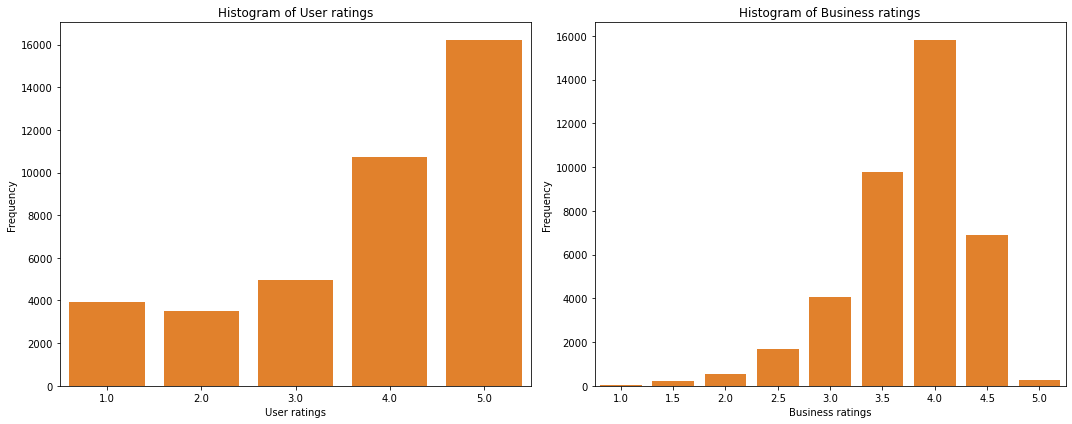

In [166]:
# Assuming you have a DataFrame named 'df' and two numerical columns 'column1' and 'column2'
column1 = 'rating'
column2 = 'b/s_rating'

# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # Adjust the figsize as needed

# Create histograms for column1 and column2
 
sns.countplot(data=data, x=column1 ,ax=axes[0] , color='tab:orange')
# Adjust the number of bins as needed
axes[0].set_xlabel("User ratings")
axes[0].set_ylabel('Frequency')
axes[0].set_title(f'Histogram of User ratings')

sns.countplot(data=data, x=column2 ,ax=axes[1] ,color='tab:orange')
  # Adjust the number of bins as needed
axes[1].set_xlabel("Business ratings")
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'Histogram of Business ratings')
# Adjust the spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

In [167]:
df_1 = data[['rating', 'b/s_rating', 'review_count']]
df_1.corr()

,rating,b/s_rating,review_count
rating,1.000000,0.409173,0.106111
b/s_rating,0.409173,1.000000,0.237139
review_count,0.106111,0.237139,1.000000


**Correlation between Rating and B/S Rating**

Correlation Value: 0.409173 The positive correlation coefficient of approximately 0.41 suggests a moderate positive relationship between the rating of a restaurant or service and its B/S Rating. In other words, as the rating of a business increases, its B/S Rating tends to increase as well. Businesses with higher individual ratings are likely to have a higher overall rating based on user reviews.

**Correlation between Rating and Review Count**

Correlation Value: 0.106111 The correlation coefficient of about 0.11 indicates a weak positive correlation between the rating of a restaurant or service and its review count.This suggests that businesses with higher ratings may have slightly more reviews, but the relationship is not particularly strong.

**Correlation between B/S Rating and Review Count**

Correlation Value: 0.237139 The correlation coefficient of approximately 0.24 suggests a moderate positive correlation between the B/S Rating of a business and its review count. This implies that businesses with higher B/S Ratings tend to have more user reviews. Customers are more likely to review businesses with higher overall ratings, contributing to the positive correlation.

#### 2.Distribution of Categories
1) What are the most prevalent restaurant categories and how does the distribution of these categories impact the restaurant landscape in terms of user preferences and choices?

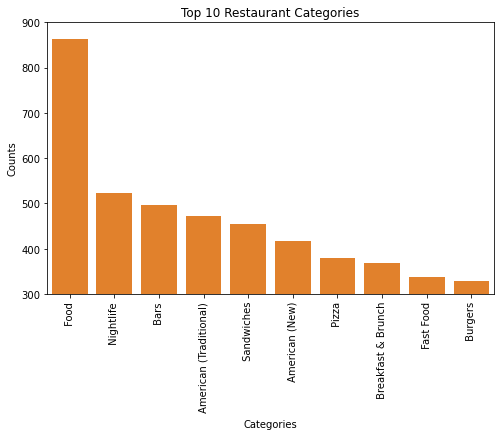

In [168]:

# list of all categories
categories=[ cat for category in data.drop_duplicates('business_id').categories for cat in category.split(',')]
# list of unique categories 
categories=collections.Counter(categories)
#picking top 20 categories
common=categories.most_common(12)
# ploting
fig, ax=plt.subplots(figsize=(8,5))
x=[ i[0] for i in common[2:]]
y=[i[1] for i in common[2:]]
sns.barplot(x=x, y=y, color='tab:orange', ax=ax)
ax.set_xlabel("Categories")
ax.tick_params(axis='x', labelrotation=90)
ax.set_ylabel("Counts")
ax.set_ylim([300,900])
ax.set_title("Top 10 Restaurant Categories");
plt.show()


#### 3 Distribution of Restaurants across the citties and states

1.CITTIES


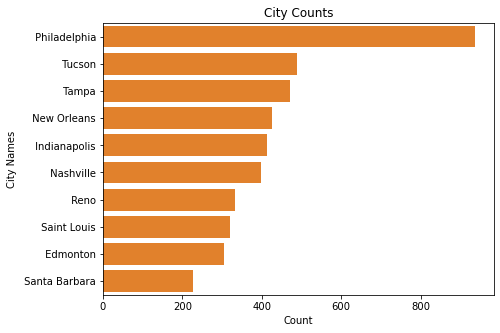

In [169]:
# extract the location column and drop duplicate business entries
location= restaurant_df.drop_duplicates('business_id')[['location']]
# split the location string to extract the city part, removing city from each entry
city=location.location.apply(lambda x: x.split(',')[1].replace("City:",'')) 
# count the occurrences of each city and selected the top 10 cities
city=collections.Counter(city)
city=city.most_common(10)
# extract the city names and their respective counts
y=[i[0] for i in city]
x=[i[1] for i in city]
# created a barplot to visualize the city counts
fig, ax=plt.subplots(figsize=(7,5))
sns.barplot( y=y, x=x, color='tab:orange')
ax.set_ylabel("City Names")
ax.set_xlabel("Count")
ax.set_title("City Counts");


From the analysis above its so clear that philadephia has the highest number of restaurantst city. Following, but not as closely, is Tampa, indicating a notable restaurant presence. In contrast, the cities of Edmonton and Santa Barbara have fewer restaurants, making them less common in this dataset.

2.STATES

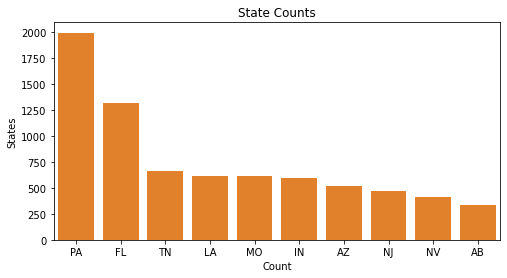

In [170]:
# extract the location column and split it to obtain the state part
states=location.location.apply(lambda x: x.split(',')[0].replace("State:",'')) 
# count the occurrences of each state and select the top 10 states
states=collections.Counter(states)
states=states.most_common(10)
# extract the state names and their respective counts for visualization
y=[i[0] for i in states]
x=[i[1] for i in states]
# created a barplot to visualize the state counts
fig, ax=plt.subplots(figsize=(8,4))
sns.barplot( y=x,x=y , color='tab:orange')
ax.set_ylabel("States")
ax.set_xlabel("Count")
ax.set_title("State Counts");

From the analysis above it is so clear  that Philadelphia has the highest number of restaurants in the dataset. Following, but not as closely, is Florida, indicating a notable presence of restaurants in that state. In contrast, Alberta and Nevada have fewer restaurants, making them less common in this dataset.

### Popular Restaurants

Analyzing and highlighting the most popular restaurants is essential because it allows us to recognize the establishments that have garnered significant attention and interest from customers. This information will be valuable for consumers seeking highly-rated dining experiences.

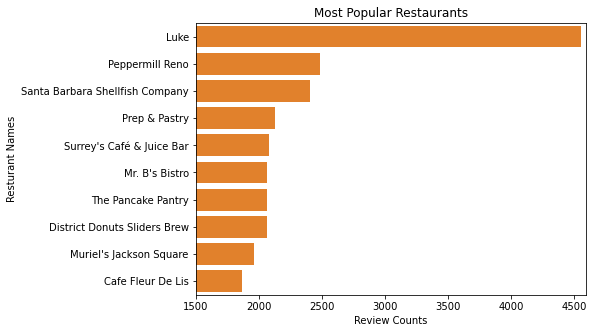

In [171]:
# most popular restaurants

index=restaurant_df.drop_duplicates(subset='business_id').sort_values(by=['review_count','b/s_rating'],ascending=False)[:10].index

fig, ax=plt.subplots(figsize=(7,5))
sns.barplot(data=restaurant_df.loc[index], x="review_count", y='name', color='tab:orange')
ax.set_ylabel("Resturant Names")
ax.set_xlabel("Review Counts")
ax.set_xlim([1500,4600])
ax.set_title("Most Popular Restaurants");


The output highlights the review counts for the different restaurants in descending order. At the top is Luke , signifying that it has received a substantial amount of customer feedback. Following closely is the Santa Barbara Shellfish Company , demonstrating a strong presence and popularity among diners. Cafe Fleur De Lis is the last on the list. These review counts offer insights into the popularity and customer engagement of these respective restaurants.

To visualize the relationship between business rating and the number of reviews more effectively, we will be creating a 2D histogram or a hexbin plot. These plots provide a better representation of the density and concentration of data points.

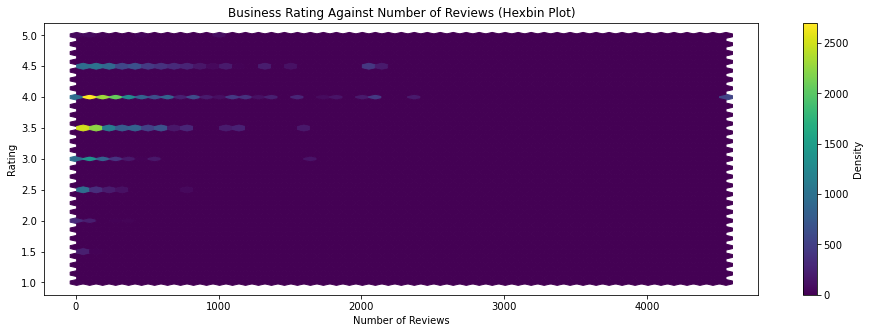

In [172]:
fig, ax = plt.subplots(figsize=(16,5))

# Create a hexbin plot
hb = ax.hexbin(data['review_count'], data['b/s_rating'], gridsize=50, cmap='viridis')

ax.set_xlabel("Number of Reviews")
ax.set_ylabel("Rating")
ax.set_title('Business Rating Against Number of Reviews (Hexbin Plot)')

# Add a colorbar to indicate the density of points
cb = plt.colorbar(hb)
cb.set_label('Density')

> From the graph, we see that, the number of reviews are increasing with increase on the restaurant rating. This means that restaurant with hight star ratings tend to have many reviews for customers.

### Interactive Map Visualization with Folium

The idea is to write a code that generates an interactive map using Folium, a Python library for creating leaflet maps. The map is centered at a specific latitude and longitude, which is determined by the first entry in the dataset. It then proceeds to populate the map with markers for selected businesses.

In [173]:
# Set up center latitude and longitude
center_lat = restaurant_df['latitude'][0]
center_long = restaurant_df['longitude'][0]

# Initialize map with center lat and long
map_ =folium.Map([center_lat,center_long], zoom_start=5)

# Adjust this limit to see more or fewer businesses
limit=1000

for index in range(limit):
    # Extract information about business
    lat = restaurant_df.loc[index,'latitude']
    long = restaurant_df.loc[index,'longitude']
    name = restaurant_df.loc[index,'name']
    rating = restaurant_df.loc[index,'b/s_rating']
    location = restaurant_df.loc[index,'location']
    details = "{}\nStars: {} {}".format(name,rating,location)
    
    # Create popup with relevant details
    popup = folium.Popup(details,parse_html=True)
    
    # Create marker with relevant lat/long and popup
    marker = folium.Marker(location=[lat,long], popup=popup)
    
    marker.add_to(map_)
    
map_

The result is an interactive map with markers representing businesses. When you click on a marker, a popup appears with details about the business, such as its name, rating, and location. This visualization provides a spatial perspective on the distribution of businesses in the dataset.